In [9]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [10]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import optuna
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from icecream import ic
from ipywidgets import interact
from polars import col
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import DataLoader, TensorDataset

from src.data.database_manager import DatabaseManager
from src.features.labels import add_labels
from src.features.resampling import (
    add_normalized_timestamp,
    interpolate_and_fill_nulls,
    resample_at_10_hz_equidistant,
)
from src.features.scaling import scale_min_max, scale_robust_standard, scale_standard
from src.features.transforming import merge_dfs
from src.features.utils import to_describe
from src.log_config import configure_logging
from src.models.architectures import LongShortTermMemory, MultiLayerPerceptron
from src.models.data_loader import create_dataloaders, transform_sample_df_to_arrays
from src.models.sample_creation import create_samples, make_sample_set_balanced
from src.models.scalers import StandardScaler3D
from src.models.utils import get_device

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

device = get_device()

23:16:07 | INFO    | root | Using device: mps


In [11]:
db = DatabaseManager()

with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )
df

trial_id,trial_number,participant_id,timestamp,temperature,rating,eda_raw,eda_tonic,eda_phasic,ppg_raw,ppg_ibi_shimmer,heartrate,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,pupil_mean_tonic,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
23,1,3,184809.3687,0.0,0.93625,3.855469,4.417003,-0.561535,1318.503562,-2.847329,69.330443,4.021351,4.492471,4.491222,4.022056,4.256639,4.309533,0.00008,0.00185,0.00251,0.0033,0.01223,0.0,658,1,0,0,111,111,67,0,0
23,1,3,184909.3687,0.000081,0.93625,3.87526,4.434407,-0.559147,1427.801949,-0.98335,69.314627,4.041885,4.502159,4.50269,4.0408,4.271745,4.316037,0.000037,0.000965,0.001661,0.001437,0.006411,100.0,658,1,0,0,111,111,67,0,0
23,1,3,185009.3687,0.000325,0.93625,3.897236,4.453884,-0.556648,1488.690007,0.783387,69.24965,4.059964,4.527155,4.527178,4.061328,4.294253,4.322598,0.000047,0.000486,0.001811,0.000719,0.006277,200.0,658,1,0,0,111,111,67,0,0
23,1,3,185109.3687,0.000887,0.93625,3.916581,4.472846,-0.556266,1459.485729,-5.07083,69.105468,4.087014,4.564178,4.563636,4.085616,4.324626,4.328764,0.00004,0.000528,0.000901,0.002076,0.006666,300.0,658,1,0,0,111,111,67,0,0
23,1,3,185209.3687,0.001743,0.93625,3.940876,4.489759,-0.548884,1433.276657,3.82947,68.885211,4.127938,4.581748,4.582575,4.12897,4.355773,4.334565,0.000049,0.000496,0.000628,0.001315,0.007096,400.0,658,1,0,0,111,111,67,0,0
23,1,3,185309.3687,0.0029,0.93625,3.973437,4.507247,-0.53381,1409.203397,-5.340423,68.558235,4.185911,4.589515,4.58934,4.186352,4.387846,4.339762,0.00001,0.000251,0.000542,0.000527,0.003068,500.0,658,1,0,0,111,111,67,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
513,12,50,2.6956e6,0.031312,0.0,26.688608,26.716225,0.003169,1323.813266,-5.036073,59.279672,5.166699,4.766597,4.768156,5.167254,4.967705,5.180142,0.000465,0.001124,0.007081,0.00022,0.004168,179500.0,806,1,2562,1537,0,0,0,0,0
513,12,50,2.6957e6,0.030874,0.0,26.68499,26.716212,0.000389,1244.871959,44.337204,58.673362,5.026438,4.683481,4.690238,5.025632,4.857935,5.174284,0.000698,0.000846,0.007044,0.000348,0.004289,179600.0,806,1,2562,1537,0,0,0,0,0


In [12]:
intervals = {
    # "decreases": "decreasing_intervals",
    "decreases": "major_decreasing_intervals",
    "increases": "strictly_increasing_intervals_without_plateaus",
    # "plateaus": "plateau_intervals",
}
label_mapping = {
    "decreases": 0,
    "increases": 1,
    # "plateaus": 1,
}
sample_duration_ms = 5000

samples = create_samples(df, intervals, sample_duration_ms, label_mapping)
samples = make_sample_set_balanced(
    samples
)  # TODO: improve balance function, different metric
samples = samples.select(
    "sample_id",
    "participant_id",
    "rating",
    "temperature",
    "eda_raw",
    "eda_tonic",
    "eda_phasic",
    "pupil_mean",
    "pupil_mean_tonic",
    "label",
)
print(samples["label"].value_counts())
samples


shape: (2, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ u8    ┆ u32   │
╞═══════╪═══════╡
│ 0     ┆ 17901 │
│ 1     ┆ 17901 │
└───────┴───────┘


sample_id,participant_id,rating,temperature,eda_raw,eda_tonic,eda_phasic,pupil_mean,pupil_mean_tonic,label
u16,u8,f64,f64,f64,f64,f64,f64,f64,u8
67,3,0.455,0.46397,6.535266,6.632551,-0.097284,3.611711,3.65844,0
67,3,0.455,0.46397,6.531334,6.634214,-0.10288,3.572473,3.655486,0
67,3,0.455,0.46397,6.529842,6.635822,-0.105981,3.544892,3.653064,0
67,3,0.455,0.46397,6.527551,6.638158,-0.110607,3.532789,3.651319,0
67,3,0.442158,0.46397,6.529655,6.640425,-0.11077,3.530868,3.650365,0
67,3,0.413454,0.46397,6.533682,6.643057,-0.109375,3.531112,3.650288,0
…,…,…,…,…,…,…,…,…,…
2684,37,0.745,0.31191,16.635482,16.600092,0.03539,4.676062,4.610185,1
2684,37,0.745,0.322781,16.636424,16.596277,0.040147,4.671875,4.60684,1


In [13]:
X, y, groups = transform_sample_df_to_arrays(
    samples,
    feature_columns=[
        # "temperature",  # only for visualization
        # "rating"
        # "eda_raw",
        # "eda_tonic",
        "pupil_mean",
    ],
)
print(f"{X.shape=}, {y.shape=}, {groups.shape=}")


@interact(trial=(0, X.shape[0] - 1))
def plot_trial(trial):
    for i in range(X.shape[2]):
        plt.plot(X[trial, :, i])
    # plt.ylim(0, 1.05)

X.shape=(702, 51, 1), y.shape=(702,), groups.shape=(702,)


interactive(children=(IntSlider(value=350, description='trial', max=701), Output()), _dom_classes=('widget-int…

In [14]:
# Create a single train-test split while respecting group structure in the data
splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
# might not be exactly 50% due to group structure
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
assert set(groups[train_idx]).isdisjoint(set(groups[test_idx])), "Overlap in groups"
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


def scale_dataset(X_train, X_test):
    # TODO scaling data fn, group-wise scaling?!
    logging.fatal("Scaling data, check if is this the right way to do it")
    scaler = StandardScaler3D()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


X_train, X_test = scale_dataset(X_train, X_test)

23:16:08 | CRITICAL| root | Scaling data, check if is this the right way to do it


In [15]:
batch_size = 64

train_loader, test_loader = create_dataloaders(
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=batch_size,
    is_test=True,
)

23:16:08 | DEBUG   | root | Train Data: 342 samples, Test Data: 360 samples


In [16]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epochs: int,
    is_test: bool = True,
) -> dict[str, list[float]]:
    dataset = "test" if is_test else "validation"
    history = {
        "train_accuracy": [],
        "train_loss": [],
        f"{dataset}_accuracy": [],
        f"{dataset}_loss": [],
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # for acc metric only
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Calculate training accuracy
            y_pred_classes = (torch.sigmoid(outputs) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total if total > 0 else 0
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

        # Store the metrics in the history dictionary
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history[f"{dataset}_loss"].append(test_loss)
        history[f"{dataset}_accuracy"].append(test_accuracy)

        # Log progress
        max_digits = len(str(epochs))
        logging.debug(
            f"E[{+epoch + 1:>{max_digits}d}/{epochs}] "
            f"| train {epoch_loss:.4f} ({epoch_acc:.1%}) "
            f"· {dataset} {test_loss:.4f} ({test_accuracy:.1%})"
        )

    return history


def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
) -> tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred_logits = model(X_batch)
            loss = criterion(y_pred_logits, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            # Metric here is acc
            y_pred_classes = (torch.sigmoid(y_pred_logits) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

    average_loss = total_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return average_loss, accuracy


In [17]:
model = LongShortTermMemory(
    input_size=X_train.shape[2], hidden_size=256, num_layers=1
).to(device)

In [18]:
lr = 1e-3
epochs = 20
model = MultiLayerPerceptron(
    input_size=X.shape[2] * X.shape[1],  # 2D input length
    hidden_size=2048,
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


history = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=epochs,
)

23:16:12 | DEBUG   | root | E[ 1/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:12 | DEBUG   | root | E[ 2/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:12 | DEBUG   | root | E[ 3/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:12 | DEBUG   | root | E[ 4/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:13 | DEBUG   | root | E[ 5/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:13 | DEBUG   | root | E[ 6/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:13 | DEBUG   | root | E[ 7/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:13 | DEBUG   | root | E[ 8/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:13 | DEBUG   | root | E[ 9/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:13 | DEBUG   | root | E[10/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:13 | DEBUG   | root | E[11/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:13 | DEBUG   | root | E[12/20] | train 0.6937 (49.1%) · test 0.6929 (50.8%)
23:16:14 | DEBUG

18:23:45 | DEBUG   | root | E[20/20] | train 0.6073 (68.1%) · test 0.6094 (67.7%)


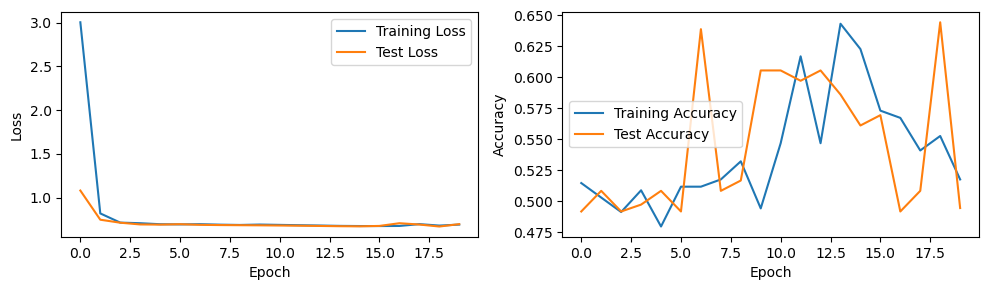

In [36]:
def plot_single_model_history(history):
    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history["train_accuracy"], label="Training Accuracy")
    plt.plot(history["test_accuracy"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_single_model_history(history)

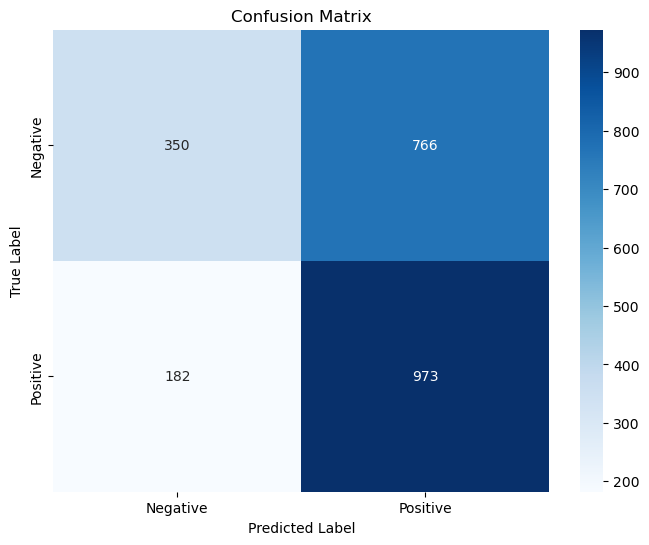

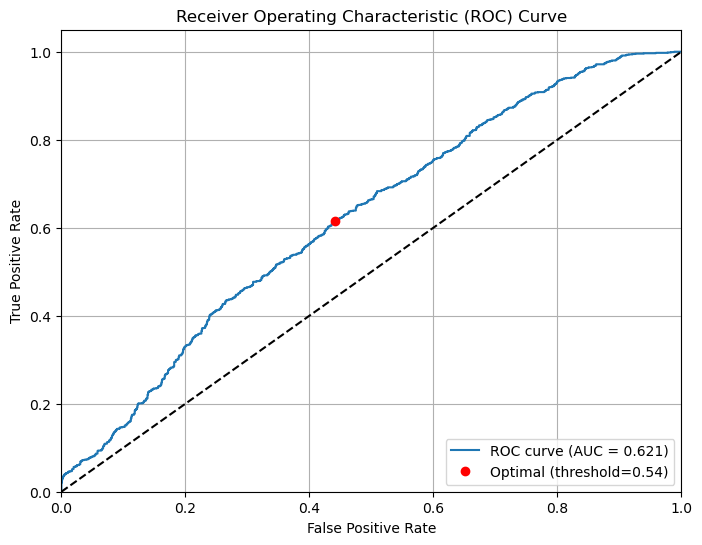

In [ ]:
def get_confusion_matrix(
    model: nn.Module,
    test_loader: DataLoader,
    threshold: float = 0.5,
) -> np.ndarray:
    """
    Calculate confusion matrix for binary classification.
    Returns a 2x2 numpy array where:
    [0,0] = TN, [0,1] = FP
    [1,0] = FN, [1,1] = TP
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_pred_batch = (torch.sigmoid(outputs) >= threshold).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(y_pred_batch)

    return confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(conf_matrix: np.ndarray) -> None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def plot_roc_curve(
    model: nn.Module,
    test_loader: DataLoader,
) -> None:
    """
    Plot ROC curve and calculate AUC score for binary classification.
    """
    model.eval()
    y_true = []
    y_scores = []

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_scores_batch = torch.sigmoid(outputs).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_scores.extend(y_scores_batch)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "k--")  # diagonal line

    # Add marker for optimal threshold
    plt.plot(
        fpr[optimal_idx],
        tpr[optimal_idx],
        "ro",
        label=f"Optimal (threshold={optimal_threshold:.2f})",
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


conf_matrix = get_confusion_matrix(model, test_loader, threshold=0.5)
plot_confusion_matrix(conf_matrix)
plot_roc_curve(model, test_loader)

In [ ]:
# from dataclasses import dataclass


# @dataclass
# class TimesNetConfig:
#     task_name: str = "classification"
#     is_training: int = 1
#     model_id: str = "Heartbeat"
#     model: str = "TimesNet"
#     data: str = "UEA"
#     e_layers: int = 3
#     batch_size: int = 16
#     d_model: int = 16
#     d_ff: int = 32
#     top_k: int = 1
#     des: str = "Exp"
#     itr: int = 1
#     learning_rate: float = 0.001
#     train_epochs: int = 30
#     patience: int = 10
#     seq_len: int = 50
#     label_len: int = 1
#     pred_len: int = 1
#     num_kernels: int = 32
#     enc_in: int = 1
#     embed: int = 8
#     freq: str = "H"
#     dropout: float = 0.1
#     num_class: int = 2

#     def to_args_list(self) -> list:
#         """Convert config to command line arguments list"""
#         args = []
#         for key, value in self.__dict__.items():
#             args.extend([f"--{key}", str(value)])
#         return args


# # Example usage:
# configs = TimesNetConfig()
# configs

# from time_series_library.models import TimesNet

# model = TimesNet.Model(configs)


In [ ]:
from sklearn.metrics import accuracy_score
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels import FlatDist, ScipyDist

eucl_dist = FlatDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=eucl_dist)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6125055041831792

In [ ]:
type(clf)

sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier

In [ ]:
isinstance(model, torch.nn.Module)

True

In [ ]:
import sktime

sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier.__mro__

(sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier,
 sktime.base._panel.knn._BaseKnnTimeSeriesEstimator,
 sktime.classification.base.BaseClassifier,
 sktime.base._base_panel.BasePanelMixin,
 sktime.base._base.BaseEstimator,
 sktime.base._base.BaseObject,
 sktime.utils._estimator_html_repr._HTMLDocumentationLinkMixin,
 skbase.base._base.BaseObject,
 skbase.base._tagmanager._FlagManager,
 object)

In [ ]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate

minirocket_multi = MiniRocketMultivariate()
# minirocket_multi.fit(X_train)


In [ ]:
X_train.shape

(2202, 500, 1)

In [5]:
Path.cwd()

PosixPath('/Users/visser/Dropbox/PhD/Code/pain-measurement')

ModuleNotFoundError: No module named 'inception_time_pytorch'

In [18]:
from src.models.inception_time_pytorch.plots import plot


In [24]:
import src.models.inception_time_pytorch.model

ModuleNotFoundError: No module named 'inception_time_pytorch'

In [29]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from src.models.inception_time_pytorch.model import InceptionTime

# Generate the data
N = 60  # number of time series
C = 10  # number of dimensions of each time series
L = 100  # number of samples of each time series
x = np.zeros((N, C, L))
t = np.linspace(0, 1, L)
c = np.cos(2 * np.pi * (10 * t - 0.5))
s = np.sin(2 * np.pi * (20 * t - 0.5))
x[: N // 3] = 20 + 20 * c + 5 * np.random.normal(size=(N // 3, C, L))
x[N // 3 : 2 * N // 3] = 20 + 20 * s + 5 * np.random.normal(size=(N // 3, C, L))
x[2 * N // 3 :] = 20 + 20 * c + 20 * s + 5 * np.random.normal(size=(N // 3, C, L))
y = np.concatenate([0 * np.ones(N // 3), 1 * np.ones(N // 3), 2 * np.ones(N // 3)])

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)

# Fit the model
model = InceptionTime(
    x=x_train,
    y=y_train,
    filters=32,
    depth=6,
    models=2,
)

model.fit(
    learning_rate=0.001,
    batch_size=64,
    epochs=50,
    verbose=True,
)

# Evaluate the model
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)
print("Training accuracy: {:.6f}".format(accuracy_score(y_train, yhat_train)))
print("Test accuracy: {:.6f}".format(accuracy_score(y_test, yhat_test)))

# Plot the results
fig = plot(x=x_test, y=yhat_test)
fig.write_image("results.png", scale=4, height=900, width=700)

Training model 1 on cpu.
epoch: 1, loss: 1.121183, accuracy: 0.333333
epoch: 2, loss: 0.534736, accuracy: 1.000000
epoch: 3, loss: 0.184575, accuracy: 1.000000
epoch: 4, loss: 0.080210, accuracy: 1.000000
epoch: 5, loss: 0.046500, accuracy: 1.000000
epoch: 6, loss: 0.031353, accuracy: 1.000000
epoch: 7, loss: 0.022778, accuracy: 1.000000
epoch: 8, loss: 0.017325, accuracy: 1.000000
epoch: 9, loss: 0.013648, accuracy: 1.000000
epoch: 10, loss: 0.011075, accuracy: 1.000000
epoch: 11, loss: 0.009209, accuracy: 1.000000
epoch: 12, loss: 0.007803, accuracy: 1.000000
epoch: 13, loss: 0.006714, accuracy: 1.000000
epoch: 14, loss: 0.005852, accuracy: 1.000000
epoch: 15, loss: 0.005157, accuracy: 1.000000
epoch: 16, loss: 0.004588, accuracy: 1.000000
epoch: 17, loss: 0.004116, accuracy: 1.000000
epoch: 18, loss: 0.003721, accuracy: 1.000000
epoch: 19, loss: 0.003386, accuracy: 1.000000
epoch: 20, loss: 0.003101, accuracy: 1.000000
epoch: 21, loss: 0.002855, accuracy: 1.000000
epoch: 22, loss: 0

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
